### Данные для ВКР

**Грузим данные**

no robots:

In [28]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/HuggingFaceH4/no_robots/" + splits["train"])

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 584e076a-a19d-4203-8c8a-f54f0bb88993)')' thrown while requesting GET https://huggingface.co/datasets/HuggingFaceH4/no_robots/resolve/main/data/train-00000-of-00001.parquet
Retrying in 1s [Retry 1/5].


beemo:

In [29]:
df2 = pd.read_parquet("hf://datasets/toloka/beemo/data/train-00000-of-00001.parquet")

**Проверяем `prompt id`**

check prompts example:

In [30]:
df.loc[df.prompt_id == df2.prompt_id[2], 'prompt']

7895    According to this statement from Chick-fil-A, ...
Name: prompt, dtype: object

In [31]:
df2.loc[df2.prompt_id == df2.prompt_id[2], 'prompt']

2    According to this statement from Chick-fil-A, ...
Name: prompt, dtype: object

**Как выглядит датасет**

<Axes: >

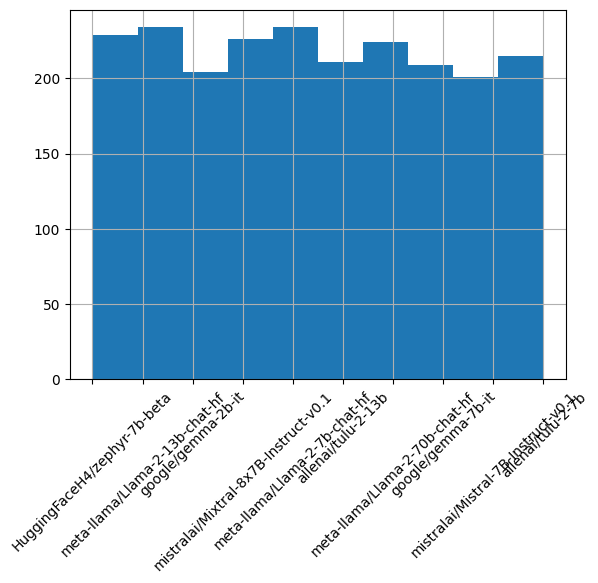

In [32]:
df2.model.hist(xrot=45)

In [33]:
df1 = df2.loc[:, ['prompt', 'model_output', 'human_output', 'human_edits']]

In [34]:
df1.head(3)

,prompt,model_output,human_output,human_edits
0,Who beat the Highland Society of Scotland in p...,Robert Armstrong beat the Highland Society of ...,Robert Armstrong released his dictionary in 18...,Robert Armstrong published a Scottish Gaelic d...
1,What family is the swordfish a part of?\nWhat ...,"Sure, I can answer your questions based on the...",Swordfish are in the family Xiphiidae.\nThe lo...,The swordfish is the only member of the family...
2,"According to this statement from Chick-fil-A, ...","According to the statement, Chick-fil-A's core...",Chick-fil-A says they do their best work throu...,"According to this statement, Chick-fil-A does ..."


**Предобработка**

Поменяем в формат `prompt | target | text`, колонка `variable` — таргет.

In [35]:
df3 = pd.melt(df1, id_vars=['prompt']).sort_values('prompt')

In [36]:
df3.head(10)

,prompt,variable,value
2294,- For what reasons does Google sometimes remov...,human_output,- Google sometimes removes content from its se...
4481,- For what reasons does Google sometimes remov...,human_edits,Google sometimes removes content from its sear...
107,- For what reasons does Google sometimes remov...,model_output,Google sometimes removes content from its sear...
166,- Who is currently serving as the UK Defence S...,model_output,The current Defence Secretary of the UK is Ben...
4540,- Who is currently serving as the UK Defence S...,human_edits,"The current UK Defence Secretary, a key figure..."
2353,- Who is currently serving as the UK Defence S...,human_output,- Ben Wallace is currently serving as the UK D...
2350,-Who now manages mascot Brutus Buckeye? \n-Whe...,human_output,-Ohio State’s cheerleading and spirit team man...
163,-Who now manages mascot Brutus Buckeye? \n-Whe...,model_output,Sure!\n\n**Who now manages mascot Brutus Bucke...
4537,-Who now manages mascot Brutus Buckeye? \n-Whe...,human_edits,The text does not specify who manages the masc...
87,1) Did Jerry Springer have a successful politi...,model_output,"Sure, here are the answers to your questions:\..."


**Аугментации**

In [3]:
import os

In [4]:
from getpass import getpass

In [6]:
os.environ["GROQ_API_KEY"] = getpass()

 ········


In [7]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 3.7 MB/s eta 0:00:00a 0:00:01


In [8]:
import os
from groq import Groq

client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

In [11]:
res = dict()

In [24]:
%%time

for i, x in df2.iterrows():
    cur_prompt = x.prompt
    if cur_prompt not in res:
        try:
            response = client.chat.completions.create(
                messages=[{"role": "user", "content": x.prompt}],
                model="llama-3.3-70b-versatile"
            )
            res[cur_prompt] = response.choices[0].message.content
        except Exception as e:
            res[cur_prompt] = str(e)
            print(e)

Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01k7ckebxcf33rjnznch95f0gn` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 100000, Requested 79. Please try again in 1m8.256s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


KeyboardInterrupt: 

In [26]:
pd.DataFrame(index=res.keys(), data=res.values()).to_csv('aug.csv')

TODO: позже сделаю джойн, когда данных будет достаточно

In [27]:
pd.DataFrame(index=res.keys(), data=res.values()).shape

(245, 1)

**BERT vectors**

In [40]:
import pandas as pd

from transformers import AutoTokenizer

from datasets import Dataset, load_dataset
from huggingface_hub import login

from transformers import DataCollatorWithPadding

import numpy as np

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [52]:
from sentence_transformers import SentenceTransformer

In [53]:
model = SentenceTransformer(r"sentence-transformers/paraphrase-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [59]:
emb_lst = dict()

In [60]:
%%time

for i, x in df3.iterrows():
    emb = model.encode(x.value)
    emb_lst[i] = emb

CPU times: user 42.1 s, sys: 402 ms, total: 42.5 s
Wall time: 41.9 s


In [80]:
df3.merge(
    right=pd.DataFrame(index=emb_lst.keys(), data=emb_lst.values()),
    how='left',
    left_index=True,
    right_index=True
).to_csv('emb.csv')